In [1]:
import numpy as np
import scipy.signal as sl
import scipy.linalg as la
import pandas as pd

from scipy.fftpack import fft, ifft, dct, idct

from matplotlib import pyplot as plt
from matplotlib.colors import to_rgba

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def figure(figsize=(10, 5)):
    plt.figure(figsize=figsize)

In [3]:
c1 = '#2b2a2b'
c2 = '#863234'
c3 = '#9f847b'

# Correlation Function

\begin{align}
     C_{AB}(\tau) \equiv \langle A B \rangle(\tau) 
         = \lim_{t_0 \rightarrow \infty} ~ \frac{1}{t_0} \int_0^{t_0} \mathrm d t ~ 
             A (t + \tau) ~ B (t)
\end{align}

In [4]:
def correlate(f1, f2):
    t0 = min(len(f1), len(f2))
    
    corr = np.zeros(t0)
    
    for t in range(t0):
        corr[t] = f1[t : t0] @ f2[: t0 - t]
        
    return corr / t0

In [5]:
# Reference data: fast + slow oscillation

t_max = 40
dt = 0.01
w1 = 1 / 1
w2 = 1/ 13

A1 = 1
A2 = 0.33

t = np.arange(0, t_max+dt, dt)
N = len(t)

In [6]:
# noise
rand = np.random.RandomState(0)

noise = (1 * rand.randn(len(t)) * ( 1 - np.exp(- t / 10)))

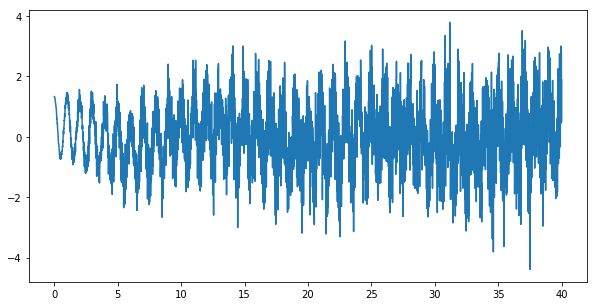

In [7]:
f = A1 * np.cos(2*np.pi * w1 * t) + A2 * np.cos(2*np.pi * w2 * t) + noise

figure()
plt.plot(t, f)

In [8]:
# mean and variance
print(f'{f.mean():.5f} +- {f.var():.5f}')

-0.01077 +- 1.15282


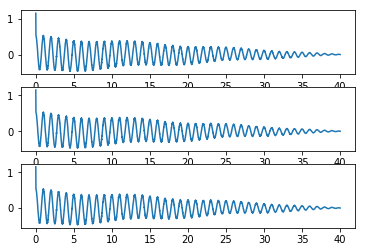

In [9]:
C = correlate(f, f)
C2 = np.correlate(f, f, 'full')[len(f)-1:] / len(f)
C2s = sl.correlate(f, f)[len(f)-1:] / len(f)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)

ax1.plot(t, C)
ax2.plot(t, C2)
ax3.plot(t, C2s)

In [10]:
all(C == C2), la.norm(C - C2s) < 1e-12

(True, True)

# Spectral Density / Power Spectrum

\begin{align}
     S(\omega) 
         = \left\vert ~
         \int_{-\infty}^{\infty} \mathrm d t ~ f(t) ~ \mathrm e^{- \mathrm i \omega t} 
         ~ \right\vert^2
\end{align}

In [11]:
k = np.linspace(0, 1 / dt, N)

S = abs(fft(f))**2

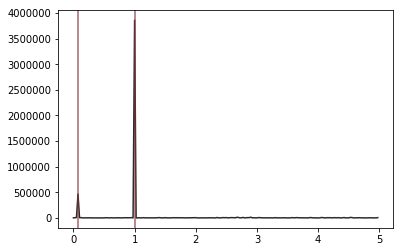

In [12]:
tm = 200
plt.plot(k[:tm], S[:tm], color=c1)
plt.axvline(w1, color=c2, alpha=0.75)
plt.axvline(w2, color=c2, alpha=0.75)

# Wiener Khintchine Theorem

\begin{align}
     S(\omega) 
         = \int_{-\infty}^{\infty} \mathrm d \tau ~ 
             C(\tau) ~ \mathrm e^{- \mathrm i \omega \tau}
         = 2 \int_{0}^{\infty} \mathrm d \tau ~ 
             C(\tau) ~ \cos(\omega \tau)
\end{align}

In [13]:
k = np.linspace(0, 1 / 2 / dt, N)

In [14]:
SWK = 2 * dct(C)

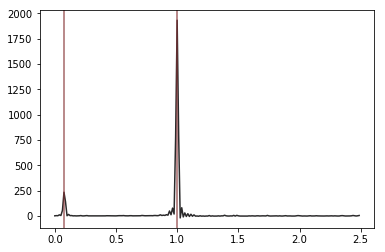

In [15]:
tm = 200
plt.plot(k[:tm], SWK[:tm], color=c1)
plt.axvline(w1, color=c2, alpha=0.75)
plt.axvline(w2, color=c2, alpha=0.75)

\begin{align}
     C(\tau) 
         = \frac{1}{2 \pi} \int_{-\infty}^{\infty} \mathrm d \omega ~ 
             S(\omega) ~ \cos(\omega \tau)
\end{align}

In [16]:
C3 = idct(S)
C4 = idct(SWK)

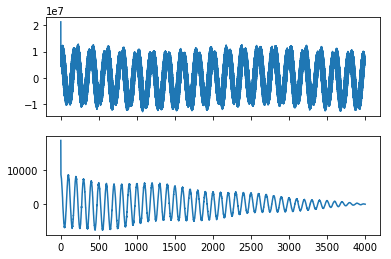

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.plot(C3)
ax2.plot(C4)

# Telegraph Equation
\begin{align}
     X(t) = (-1)^{N(t)}~,
\end{align}

where $N(t)$ is the number of events generated by a Poisson process in the time interval $[0, t)$.

A Poisson process can be modelled as and infinitely dense series of coin tosses with a probability

$$ P(\text{Head}) = \lambda \mathrm d t $$
to flip a head.

The probability of tossing $n$ times a head within $[0, t)$ is then given by

$$ P(N=n, t) = \frac{(\lambda t)^n ~ \mathrm{e}^{-\lambda t}}{n!}~.$$

See https://www.probabilitycourse.com/chapter11/11_1_2_basic_concepts_of_the_poisson_process.php

In [18]:
lam = 1

nt = 10000
ts = np.linspace(0, 500, nt)
dt = ts[1] - ts[0]
dt, lam * dt

(0.05000500050005, 0.05000500050005)

In [19]:
sample = np.zeros(nt)

rand = np.random.RandomState(1)
rands = rand.rand(nt)
sample[rands < lam*dt] = 1
sample.sum()

499.0

In [20]:
signal = (-1) ** sample.cumsum()

(0, 20)

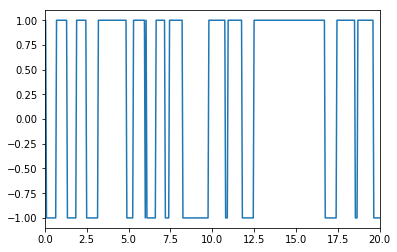

In [21]:
plt.plot(ts, signal)
plt.xlim([0, 20])

In [22]:
%%time
C_telegraph = correlate(signal, signal)

CPU times: user 119 ms, sys: 3.61 ms, total: 123 ms
Wall time: 30.6 ms


In [23]:
%%time
C_telegraph = np.correlate(signal, signal, mode='full')[nt-1:] / nt

CPU times: user 104 ms, sys: 0 ns, total: 104 ms
Wall time: 25.7 ms


In [24]:
%%time
C_telegraph = sl.correlate(signal, signal)[nt-1:] / nt

CPU times: user 5.54 ms, sys: 4 µs, total: 5.55 ms
Wall time: 1.28 ms


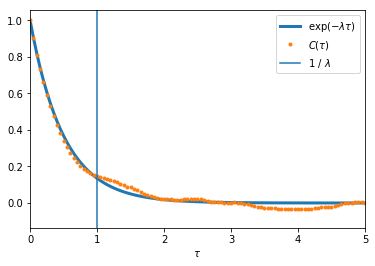

In [25]:
fig, ax = plt.subplots()

ax.plot(ts, np.exp(-  2 * ts * lam), linewidth=3)
ax.plot(ts, C_telegraph, '.')
ax.set_xlim([0, 5 * 1 / lam])
ax.axvline(1 / lam)

ax.legend([r'$\exp(- \lambda \tau)$', r'$C (\tau)$', '1 / $\lambda$'])
ax.set_xlabel(r'$\tau$')

plt.show()